<a href="https://colab.research.google.com/github/Chathu-MSBA/AML-64061/blob/main/Assignment%2003/AML_Assignment_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting Google Drive in Google Colab**

In [5]:
from google.colab import drive

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd

**Extracting a Zip File in Google Colab**

In [8]:
import zipfile
import os

# Path to the zip file in your Google Drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/Data /jena_climate_2009_2016.csv.zip'

# Destination directory where you want to extract the files
extract_path = '/content/data/'

# Create the destination directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [9]:
# Create the destination directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

In [10]:
# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

**Reading and Parsing CSV Data in Google Colab**

In [11]:
import os

# Specify the name of the CSV file
csv_filename = "jena_climate_2009_2016.csv"

# Construct the full path to the CSV file
csv_filepath = os.path.join(extract_path, csv_filename)

# Open the CSV file and read its contents
with open(csv_filepath) as f:
    data = f.read()

# Split the data into lines
lines = data.split("\n")

# Extract header and data
header = lines[0].split(",")
lines = lines[1:]

# Print header and number of lines
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Plotting Temperature Data Using Matplotlib**

In [12]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

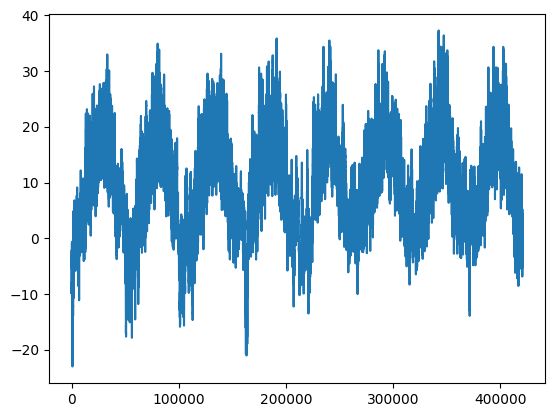

In [13]:
 from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

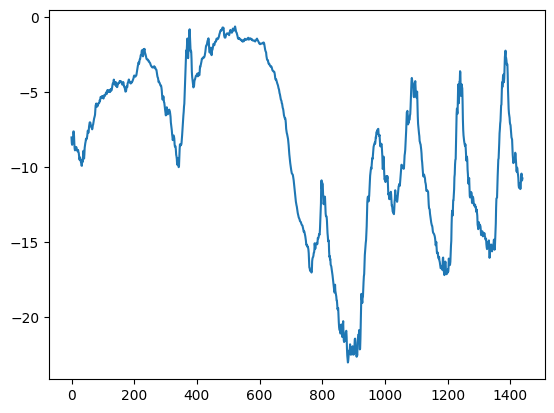

In [14]:
plt.plot(range(1440), temperature[:1440])


**Splitting Dataset into Train, Validation, and Test Sets**

In [15]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**Standardizing Data**

In [16]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [17]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [18]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting Train Dataset Shapes**

In [19]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**Evaluating Naive Forecast Method**

In [20]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


*In simpler terms, if we were to predict future temperatures by assuming they remain the same as the current temperature, on average, we'd be off by about 2.62 degrees Celsius. This suggests that our forecasting model, while not perfect, performs better than this simplistic approach, providing more accurate predictions.*

# Basic ML Model
**Training and evaluating a densely connected model**

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)



Epoch 1/10
819/819 [==============================] - 40s 48ms/step - loss: 12.3563 - mae: 2.7328 - val_loss: 10.5185 - val_mae: 2.5497
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 9.1049 - mae: 2.3708 - val_loss: 10.6128 - val_mae: 2.5636
Epoch 3/10
819/819 [==============================] - 39s 48ms/step - loss: 8.2652 - mae: 2.2635 - val_loss: 10.8876 - val_mae: 2.5866
Epoch 4/10
819/819 [==============================] - 38s 47ms/step - loss: 7.7708 - mae: 2.1956 - val_loss: 10.5094 - val_mae: 2.5663
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 7.4806 - mae: 2.1538 - val_loss: 10.5511 - val_mae: 2.5547
Epoch 6/10
819/819 [==============================] - 37s 45ms/step - loss: 7.2157 - mae: 2.1168 - val_loss: 10.5718 - val_mae: 2.5608
Epoch 7/10
819/819 [==============================] - 39s 48ms/step - loss: 7.0238 - mae: 2.0881 - val_loss: 10.6685 - val_mae: 2.5733
Epoch 8/10
819/819 [==============================] - 

In [23]:
model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 30ms/step - loss: 11.6759 - mae: 2.6889
Test MAE: 2.69


In [25]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x) # Tried different dense units of 8, 32, 64 apart from 16 which is given in actual code
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 50s 60ms/step - loss: 12.5200 - mae: 2.7425 - val_loss: 10.6385 - val_mae: 2.5810
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 8.6189 - mae: 2.3102 - val_loss: 13.5979 - val_mae: 2.9192
Epoch 3/10
819/819 [==============================] - 47s 58ms/step - loss: 7.5028 - mae: 2.1520 - val_loss: 10.7439 - val_mae: 2.5734
Epoch 4/10
819/819 [==============================] - 50s 60ms/step - loss: 6.7398 - mae: 2.0415 - val_loss: 10.9324 - val_mae: 2.6127
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 6.1947 - mae: 1.9584 - val_loss: 13.2848 - val_mae: 2.9106
Epoch 6/10
819/819 [==============================] - 44s 54ms/step - loss: 5.7811 - mae: 1.8923 - val_loss: 12.6457 - val_mae: 2.8025
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 5.4547 - mae: 1.8394 - val_loss: 11.7628 - val_mae: 2.6841
Epoch 8/10
819/819 [==============================] - 

In [26]:
model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 31ms/step - loss: 11.8205 - mae: 2.7003
Test MAE: 2.70


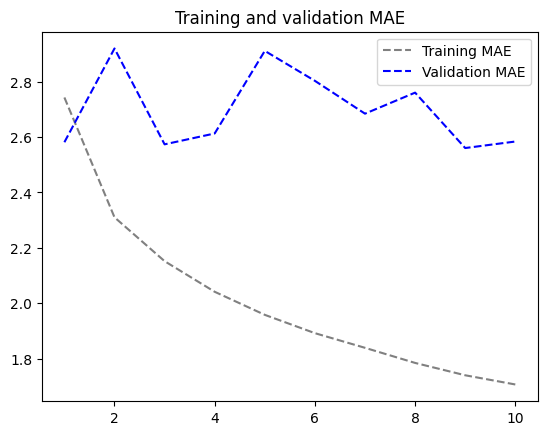

In [27]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs, val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**1D convolutional model**

In [28]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
conv_x = layers.Conv1D(8, 24, activation="relu")(inputs)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 12, activation="relu")(conv_x)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 6, activation="relu")(conv_x)
conv_x = layers.GlobalAveragePooling1D()(conv_x)
outputs = layers.Dense(1)(conv_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.conv_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.conv_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 54ms/step - loss: 23.9648 - mae: 3.8255 - val_loss: 16.5960 - val_mae: 3.2604
Epoch 2/10
819/819 [==============================] - 49s 60ms/step - loss: 17.3417 - mae: 3.2949 - val_loss: 15.9867 - val_mae: 3.1367
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 15.2353 - mae: 3.1012 - val_loss: 14.1340 - val_mae: 2.9748
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 14.3154 - mae: 3.0060 - val_loss: 14.3426 - val_mae: 2.9745
Epoch 5/10
819/819 [==============================] - 44s 54ms/step - loss: 13.7358 - mae: 2.9407 - val_loss: 14.0312 - val_mae: 2.9351
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 13.2142 - mae: 2.8851 - val_loss: 13.4767 - val_mae: 2.8947
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 12.8822 - mae: 2.8468 - val_loss: 13.4216 - val_mae: 2.8848
Epoch 8/10
819/819 [============================

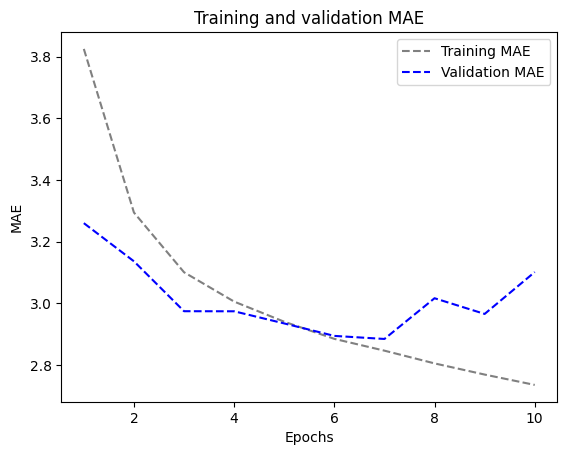

In [29]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# **A Simple RNN**
**Building and Training a SimpleRNN Model**

In [30]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 111s 134ms/step - loss: 138.5560 - mae: 9.6724 - val_loss: 143.9604 - val_mae: 9.8935
Epoch 2/10
819/819 [==============================] - 107s 131ms/step - loss: 136.3575 - mae: 9.5549 - val_loss: 143.6920 - val_mae: 9.8622
Epoch 3/10
819/819 [==============================] - 103s 126ms/step - loss: 136.4219 - mae: 9.5605 - val_loss: 143.7942 - val_mae: 9.8797
Epoch 4/10
819/819 [==============================] - 104s 127ms/step - loss: 136.5232 - mae: 9.5704 - val_loss: 143.8271 - val_mae: 9.8837
Epoch 5/10
819/819 [==============================] - 106s 129ms/step - loss: 136.4172 - mae: 9.5618 - val_loss: 143.8960 - val_mae: 9.8901
Epoch 6/10
819/819 [==============================] - 116s 142ms/step - loss: 136.4370 - mae: 9.5642 - val_loss: 143.7763 - val_mae: 9.8810
Epoch 7/10
819/819 [==============================] - 104s 126ms/step - loss: 136.3281 - mae: 9.5545 - val_loss: 143.8111 - val_mae: 9.8837
Epoch 8/10
819/819 [

**Building and Training a Stacked SimpleRNN Model**

In [31]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 337s 409ms/step - loss: 137.1767 - mae: 9.5813 - val_loss: 143.4660 - val_mae: 9.8452
Epoch 2/10
819/819 [==============================] - 341s 416ms/step - loss: 135.9422 - mae: 9.5121 - val_loss: 143.3823 - val_mae: 9.8345
Epoch 3/10
819/819 [==============================] - 301s 366ms/step - loss: 135.9124 - mae: 9.5080 - val_loss: 143.3997 - val_mae: 9.8342
Epoch 4/10
819/819 [==============================] - 303s 370ms/step - loss: 135.8876 - mae: 9.5039 - val_loss: 143.3695 - val_mae: 9.8328
Epoch 5/10
819/819 [==============================] - 295s 360ms/step - loss: 135.8670 - mae: 9.5012 - val_loss: 143.3826 - val_mae: 9.8345
Epoch 6/10
819/819 [==============================] - 298s 364ms/step - loss: 135.8561 - mae: 9.4990 - val_loss: 143.4086 - val_mae: 9.8406
Epoch 7/10
819/819 [==============================] - 298s 364ms/step - loss: 135.8373 - mae: 9.4964 - val_loss: 143.4107 - val_mae: 9.8400
Epoch 8/10
819/819 [

#**A Simple GRU (Gated Recurrent Unit)**


In [32]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 46s 53ms/step - loss: 41.6549 - mae: 4.6772 - val_loss: 12.4438 - val_mae: 2.6529
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 10.4554 - mae: 2.5152 - val_loss: 9.4795 - val_mae: 2.3870
Epoch 3/10
819/819 [==============================] - 49s 60ms/step - loss: 9.5183 - mae: 2.4085 - val_loss: 9.1308 - val_mae: 2.3410
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 9.2541 - mae: 2.3733 - val_loss: 9.0579 - val_mae: 2.3320
Epoch 5/10
819/819 [==============================] - 50s 60ms/step - loss: 9.0628 - mae: 2.3492 - val_loss: 9.2165 - val_mae: 2.3539
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 8.8806 - mae: 2.3257 - val_loss: 9.3355 - val_mae: 2.3742
Epoch 7/10
819/819 [==============================] - 51s 62ms/step - loss: 8.7110 - mae: 2.3031 - val_loss: 9.3556 - val_mae: 2.3757
Epoch 8/10
819/819 [==============================] - 41s 5

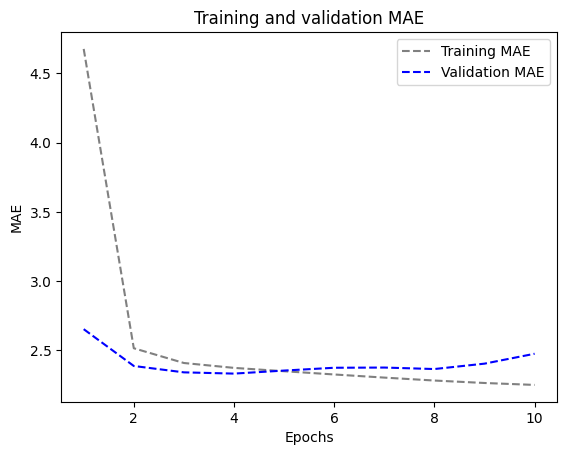

In [33]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **LSTM(Long Short-Term Memory)**
**LSTM-Simple**


In [34]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 52ms/step - loss: 39.1900 - mae: 4.5643 - val_loss: 12.4538 - val_mae: 2.6971
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 10.9727 - mae: 2.5770 - val_loss: 9.6095 - val_mae: 2.4172
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 9.7337 - mae: 2.4307 - val_loss: 9.6764 - val_mae: 2.4118
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 9.1185 - mae: 2.3512 - val_loss: 9.3450 - val_mae: 2.3623
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 8.7587 - mae: 2.3046 - val_loss: 9.6360 - val_mae: 2.4023
Epoch 6/10
819/819 [==============================] - 52s 63ms/step - loss: 8.4405 - mae: 2.2683 - val_loss: 9.5388 - val_mae: 2.3910
Epoch 7/10
819/819 [==============================] - 50s 60ms/step - loss: 8.2224 - mae: 2.2425 - val_loss: 10.2592 - val_mae: 2.4666
Epoch 8/10
819/819 [==============================] - 42s 

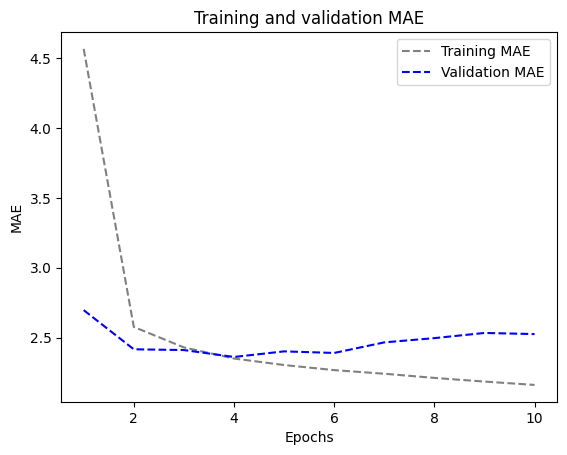

In [35]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - dropout Regularization**

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 304s 366ms/step - loss: 45.3658 - mae: 5.0285 - val_loss: 13.0859 - val_mae: 2.7363
Epoch 2/10
819/819 [==============================] - 306s 373ms/step - loss: 20.0193 - mae: 3.4365 - val_loss: 9.8290 - val_mae: 2.4367
Epoch 3/10
819/819 [==============================] - 304s 371ms/step - loss: 18.1267 - mae: 3.2747 - val_loss: 9.5643 - val_mae: 2.4088
Epoch 4/10
819/819 [==============================] - 304s 372ms/step - loss: 17.2248 - mae: 3.1958 - val_loss: 9.1749 - val_mae: 2.3650
Epoch 5/10
819/819 [==============================] - 305s 372ms/step - loss: 16.7451 - mae: 3.1460 - val_loss: 9.3186 - val_mae: 2.3725
Epoch 6/10
819/819 [==============================] - 304s 371ms/step - loss: 16.3033 - mae: 3.1076 - val_loss: 9.2543 - val_mae: 2.3712
Epoch 7/10
819/819 [==============================] - 305s 373ms/step - loss: 15.8437 - mae: 3.0665 - val_loss: 9.5070 - val_mae: 2.3971
Epoch 8/10
819/819 [====================

405/405 [==============================] - 29s 70ms/step - loss: 11.0630 - mae: 2.6247
Test MAE: 2.62


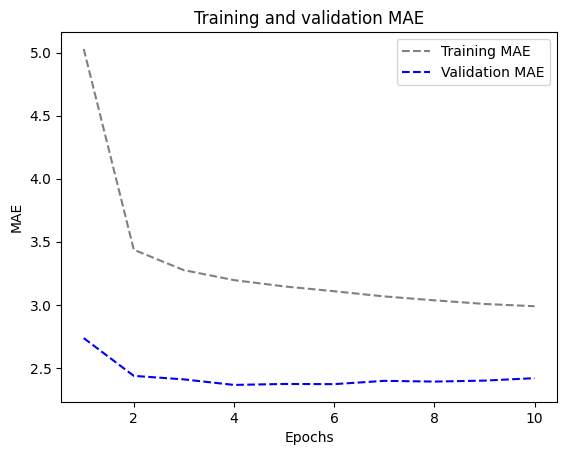

In [37]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - Stacked setup with 16 units**


In [38]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 56ms/step - loss: 37.9896 - mae: 4.4879 - val_loss: 12.6332 - val_mae: 2.6955
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 10.4366 - mae: 2.5056 - val_loss: 9.9917 - val_mae: 2.4610
Epoch 3/10
819/819 [==============================] - 44s 54ms/step - loss: 8.8063 - mae: 2.3112 - val_loss: 10.4615 - val_mae: 2.5300
Epoch 4/10
819/819 [==============================] - 53s 65ms/step - loss: 8.0264 - mae: 2.2063 - val_loss: 10.8208 - val_mae: 2.5680
Epoch 5/10
819/819 [==============================] - 44s 54ms/step - loss: 7.5656 - mae: 2.1426 - val_loss: 11.4008 - val_mae: 2.6153
Epoch 6/10
819/819 [==============================] - 52s 64ms/step - loss: 7.1895 - mae: 2.0880 - val_loss: 11.3861 - val_mae: 2.6364
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 6.9198 - mae: 2.0470 - val_loss: 11.9809 - val_mae: 2.7083
Epoch 8/10
819/819 [==============================] - 

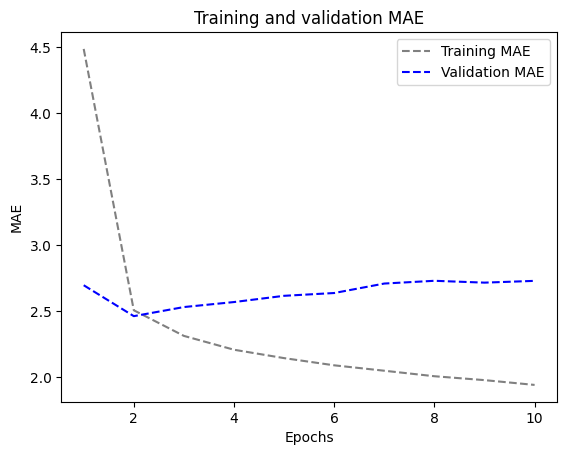

In [39]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - Stacked setup with 32 units**

In [40]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 57s 66ms/step - loss: 19.4360 - mae: 3.1944 - val_loss: 10.0244 - val_mae: 2.4639
Epoch 2/10
819/819 [==============================] - 45s 55ms/step - loss: 8.0153 - mae: 2.2019 - val_loss: 11.9179 - val_mae: 2.6904
Epoch 3/10
819/819 [==============================] - 54s 65ms/step - loss: 6.3563 - mae: 1.9464 - val_loss: 12.0983 - val_mae: 2.7045
Epoch 4/10
819/819 [==============================] - 56s 68ms/step - loss: 5.1991 - mae: 1.7524 - val_loss: 13.0842 - val_mae: 2.8251
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 4.4132 - mae: 1.6081 - val_loss: 13.5944 - val_mae: 2.8556
Epoch 6/10
819/819 [==============================] - 45s 55ms/step - loss: 3.8545 - mae: 1.4994 - val_loss: 13.6438 - val_mae: 2.8844
Epoch 7/10
819/819 [==============================] - 48s 58ms/step - loss: 3.4483 - mae: 1.4198 - val_loss: 14.3605 - val_mae: 2.9585
Epoch 8/10
819/819 [==============================] - 

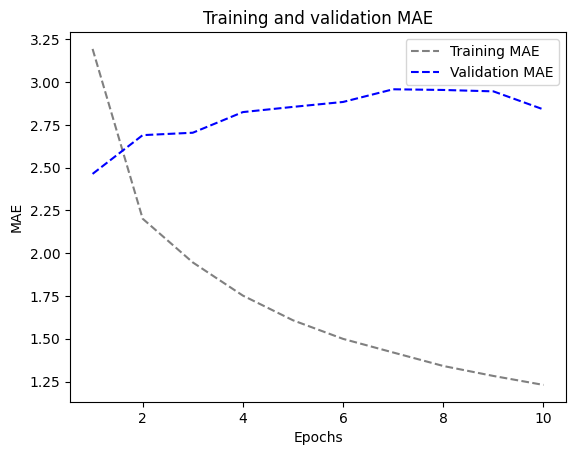

In [41]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - Stacked setup with 8 units**

In [42]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 60s 70ms/step - loss: 69.7949 - mae: 6.3803 - val_loss: 34.2374 - val_mae: 4.3789
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 20.8810 - mae: 3.3937 - val_loss: 12.7836 - val_mae: 2.7037
Epoch 3/10
819/819 [==============================] - 46s 56ms/step - loss: 11.2203 - mae: 2.5855 - val_loss: 9.9674 - val_mae: 2.4647
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.9427 - mae: 2.4486 - val_loss: 9.6791 - val_mae: 2.4244
Epoch 5/10
819/819 [==============================] - 45s 54ms/step - loss: 9.4851 - mae: 2.3927 - val_loss: 9.2877 - val_mae: 2.3657
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 9.0300 - mae: 2.3409 - val_loss: 9.5963 - val_mae: 2.4066
Epoch 7/10
819/819 [==============================] - 53s 65ms/step - loss: 8.7434 - mae: 2.3069 - val_loss: 9.4255 - val_mae: 2.3882
Epoch 8/10
819/819 [==============================] - 53s

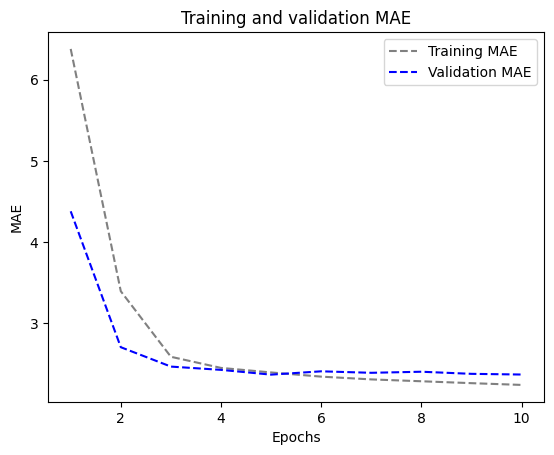

In [43]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**LSTM - dropout-regularized, stacked model**

In [44]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 631s 764ms/step - loss: 68.7058 - mae: 6.3446 - val_loss: 32.5173 - val_mae: 4.2357
Epoch 2/10
819/819 [==============================] - 602s 735ms/step - loss: 30.7006 - mae: 4.1455 - val_loss: 13.5204 - val_mae: 2.7498
Epoch 3/10
819/819 [==============================] - 608s 743ms/step - loss: 24.1982 - mae: 3.7282 - val_loss: 11.1456 - val_mae: 2.5586
Epoch 4/10
819/819 [==============================] - 611s 746ms/step - loss: 22.4564 - mae: 3.5921 - val_loss: 10.5441 - val_mae: 2.5046
Epoch 5/10
819/819 [==============================] - 626s 764ms/step - loss: 21.2116 - mae: 3.4989 - val_loss: 10.3469 - val_mae: 2.4909
Epoch 6/10
819/819 [==============================] - 612s 747ms/step - loss: 20.1944 - mae: 3.4195 - val_loss: 10.0963 - val_mae: 2.4650
Epoch 7/10
819/819 [==============================] - 618s 754ms/step - loss: 19.5542 - mae: 3.3626 - val_loss: 10.3127 - val_mae: 2.4822
Epoch 8/10
819/819 [==============

405/405 [==============================] - 42s 102ms/step - loss: 11.1213 - mae: 2.5941
Test MAE: 2.59


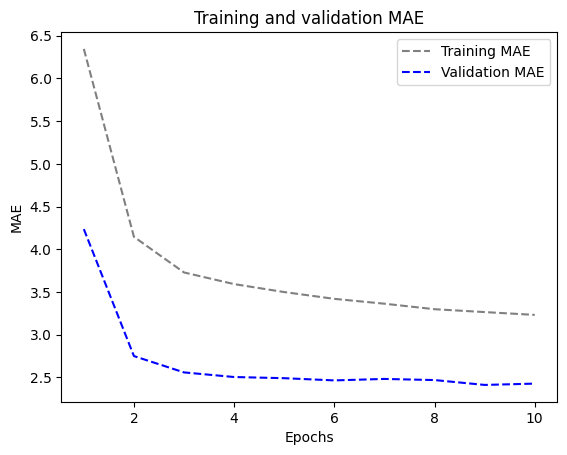

In [45]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# **Bidirectional LSTM**


In [46]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 57s 65ms/step - loss: 27.5674 - mae: 3.7693 - val_loss: 10.6979 - val_mae: 2.5299
Epoch 2/10
819/819 [==============================] - 45s 54ms/step - loss: 9.4694 - mae: 2.4003 - val_loss: 9.7062 - val_mae: 2.4254
Epoch 3/10
819/819 [==============================] - 44s 54ms/step - loss: 8.3846 - mae: 2.2528 - val_loss: 9.9162 - val_mae: 2.4552
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 7.8032 - mae: 2.1804 - val_loss: 9.8649 - val_mae: 2.4338
Epoch 5/10
819/819 [==============================] - 52s 64ms/step - loss: 7.4212 - mae: 2.1293 - val_loss: 10.0795 - val_mae: 2.4518
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 7.2111 - mae: 2.0991 - val_loss: 10.3832 - val_mae: 2.4923
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 7.0341 - mae: 2.0702 - val_loss: 10.7504 - val_mae: 2.5359
Epoch 8/10
819/819 [==============================] - 45s

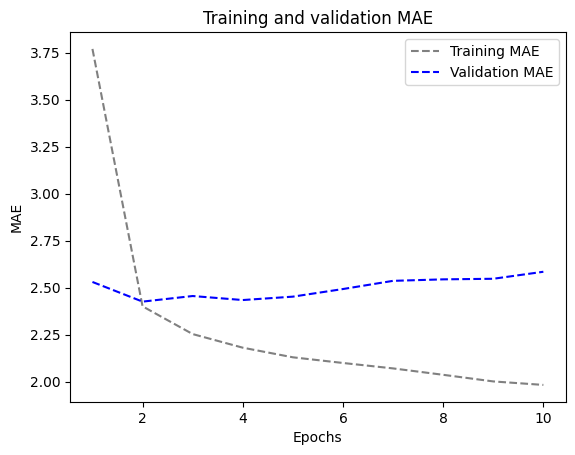

In [47]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

#**1D Convnets and LSTM togther**

In [48]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 61ms/step - loss: 46.4662 - mae: 5.0863 - val_loss: 26.5559 - val_mae: 3.9777
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 17.3687 - mae: 3.2175 - val_loss: 21.0562 - val_mae: 3.6221
Epoch 3/10
819/819 [==============================] - 50s 61ms/step - loss: 14.3739 - mae: 2.9400 - val_loss: 22.2912 - val_mae: 3.7383
Epoch 4/10
819/819 [==============================] - 49s 60ms/step - loss: 12.8266 - mae: 2.7734 - val_loss: 26.2368 - val_mae: 4.1376
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 11.7677 - mae: 2.6530 - val_loss: 22.7668 - val_mae: 3.8109
Epoch 6/10
819/819 [==============================] - 49s 60ms/step - loss: 10.9471 - mae: 2.5532 - val_loss: 23.0513 - val_mae: 3.8154
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 10.2556 - mae: 2.4654 - val_loss: 26.4448 - val_mae: 4.0580
Epoch 8/10
819/819 [============================

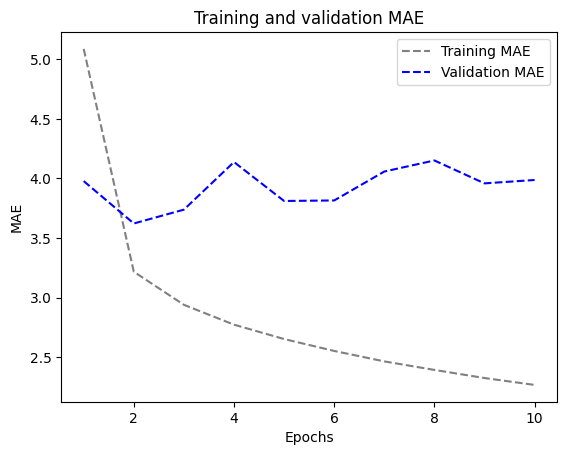

In [49]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

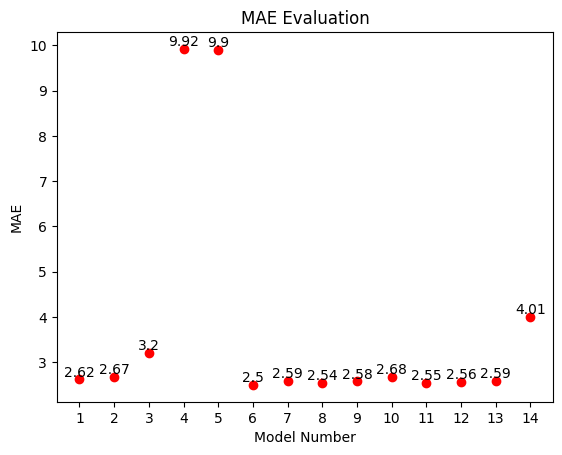

In [50]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14")
Mae = (2.62,2.67,3.2,9.92,9.9,2.5,2.59,2.54,2.58,2.68,2.55,2.56,2.59,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()